## 1) Cài đặt thư viện

In [1]:
!pip install lightning
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 40.7 MB/s eta 0:00:00


## 2) Chuẩn bị dữ liệu
- 2.1 upload dữ liệu hình ảnh các loại bệnh về cá
- 2.2 chạy code sau để giải nén

In [11]:
# Lưu ý: code này chỉ chạy 1 lần đầu, các lần khác không chạy nữa
import os

%cd /content/drive/MyDrive/Colab Notebooks/

folder_path = "Freshwater Fish Disease Aquaculture in south asia"
if os.path.exists(folder_path):
    print(f"Thư mục '{folder_path}' đã tồn tại.")
else:
    print(f"Thư mục '{folder_path}' không tồn tại.")
    !unzip FishDeseaseDataset.zip

/content/drive/MyDrive/Colab Notebooks
Thư mục 'Freshwater Fish Disease Aquaculture in south asia' đã tồn tại.


In [3]:
%cd /content/drive/MyDrive/Colab Notebooks/
dataset_dir = '/content/drive/MyDrive/Colab Notebooks/Freshwater Fish Disease Aquaculture in south asia'

/content/drive/MyDrive/Colab Notebooks


## 3) Local utilities

In [55]:
import lightning as L
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import torch
import torch.nn.functional as F
import torchmetrics
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
from torchvision import transforms


def get_model_list():
    model_list = ["resnet18"] #, "resnet34", "resnet50", "resnet101", "resnet152"
    # entrypoints = torch.hub.list('pytorch/vision', force_reload=True)
    # for e in entrypoints:
    #     if e.startswith("resnet"):
    #         model_list.append(e)
    return model_list

class LightningModel(L.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()

        self.learning_rate = learning_rate
        self.model = model

        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=7)
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=7)
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=7)

    def forward(self, x):
        return self.model(x)

    def _shared_step(self, batch):
        features, true_labels = batch
        logits = self(features)

        loss = F.cross_entropy(logits, true_labels)
        predicted_labels = torch.argmax(logits, dim=1)
        return loss, true_labels, predicted_labels

    def training_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)

        self.log("train_loss", loss)
        self.train_acc(predicted_labels, true_labels)
        self.log(
            "train_acc", self.train_acc, prog_bar=True, on_epoch=True, on_step=False
        )
        return loss

    def validation_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)

        self.log("val_loss", loss, prog_bar=True)
        self.val_acc(predicted_labels, true_labels)
        self.log("val_acc", self.val_acc, prog_bar=True)

    def test_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.test_acc(predicted_labels, true_labels)
        self.log("test_acc", self.test_acc)

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
        return optimizer


def plot_csv_logger(
    csv_path, model_name, loss_names=["train_loss", "val_loss"], eval_names=["train_acc", "val_acc"]
):

    metrics = pd.read_csv(csv_path)

    aggreg_metrics = []
    agg_col = "epoch"
    for i, dfg in metrics.groupby(agg_col):
        agg = dict(dfg.mean())
        agg[agg_col] = i
        aggreg_metrics.append(agg)

    df_metrics = pd.DataFrame(aggreg_metrics)

    df_metrics[loss_names].plot(grid=True, legend=True, xlabel="Epoch", ylabel="Loss")
    plt.savefig(f'{model_name}-loss.png')

    df_metrics[eval_names].plot(grid=True, legend=True, xlabel="Epoch", ylabel="ACC")
    plt.savefig(f'{model_name}-acc.png')


# Freshwater Fish Disease dataset
class FishDiseaseDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.transform = transform
        self.build_label_index(img_dir)
        self.init_data(img_dir)

    def __getitem__(self, index):
        # print(f'getting image {self.images[index]} with label {self.labels[index]}')

        img = Image.open(self.images[index]).convert('RGB')

        if self.transform is not None:
            img = self.transform(img)

        # Only return the label if it exists (for training/validation)
        if hasattr(self, 'labels'):
            label = self.label_index[self.labels[index]]
            return img, label
        else: #If you only want the image(like in the single image case)
            return img

    def __len__(self):
        # Check if 'labels' attribute exists before accessing it
        if hasattr(self, 'labels'):
            return len(self.labels)
        else:
            return len(self.images) #return the number of images if there are no labels for this dataset

    def build_label_index(self, img_dir):
        base_dir = os.path.join(img_dir, 'Train') # ./Freshwater Fish Disease Aquaculture in south asia/Train
        self.label_index = {}
        for idx, label in enumerate(os.listdir(base_dir)):
            # print(f'index={idx}, label={label}')
            self.label_index[label] = idx # cập nhật lại chỉ số tên nhãn từ tên folder Bacterial diseases - Aeromoniasis
        print("Label_index: ",self.label_index)
        # print(f'Total lables = {len(self.label_index)}')

class FishDiseaseTrainDataset(FishDiseaseDataset):
    def init_data(self, img_dir):
        self.images = []
        self.labels = []

        base_dir = os.path.join(img_dir, 'Train') # tạo đường dẫn đi đến thư mục train trong bộ dữ liệu FishDisease

        for label in os.listdir(base_dir): # duyệt qua các thư mục trong train: ví dụ: Bacterial diseases - Aeromoniasis, Bacterial gill disease....
            label_dir = os.path.join(base_dir, label) # tạo đường dẫn đi đến các ảnh trong thư mục, ví dụ ./Freshwater Fish Disease Aquaculture in south asia/Train/Bacterial diseases - Aeromoniasis/,....
            for img in os.listdir(label_dir): # duyệt qua các ảnh trong thư mục ./Freshwater Fish Disease Aquaculture in south asia/Train/Bacterial diseases - Aeromoniasis/
                self.images.append(os.path.join(label_dir, img)) # thêm đường dẫn ảnh vào list images
                self.labels.append(label) # thêm nhãn vào list labels


class FishDiseaseTestDataset(FishDiseaseDataset):
    def init_data(self, img_dir):
        self.images = []
        self.labels = []

        base_dir = os.path.join(img_dir, 'Test')

        for label in os.listdir(base_dir):
            label_dir = os.path.join(base_dir, label)
            if os.path.isdir(label_dir):  # Kiểm tra xem label_dir có phải là thư mục không
                for img in os.listdir(label_dir):
                    self.images.append(os.path.join(label_dir, img))
                    self.labels.append(label)

class FishDiseaseSingleImage(FishDiseaseDataset):
    def init_data(self, img_dir):
        self.images = []

        base_dir = os.path.join(img_dir, 'Single')
        # Check if the 'Single' directory exists and contains images
        if os.path.exists(base_dir) and os.listdir(base_dir):
            for img in os.listdir(base_dir):
                # Append the full path to the image
                self.images.append(os.path.join(base_dir, img))
        else:
            print("Warning: 'Single' directory not found or empty. No images loaded.")

class FishDiseaseDataModule(L.LightningDataModule):
    def __init__(
        self,
        data_path=dataset_dir, # Chú ý: đường dẫn đến thư mục bộ dữ liệu đã giải nén
        batch_size=16,
        height_width=None,
        num_workers=0,
        augment_data=False,
    ):
        super().__init__()

        self.data_path = data_path
        self.batch_size = batch_size
        self.height_width = height_width
        self.num_workers = num_workers


        if augment_data:
            self.train_transform = transforms.Compose(
                [
                    transforms.Resize((250, 250)),
                    transforms.RandomCrop(self.height_width),
                    transforms.RandomHorizontalFlip(p=0.2),
                    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                    transforms.ToTensor(),
                ]
            )

            self.test_transform = transforms.Compose(
                [
                    transforms.Resize((250, 250)),
                    transforms.CenterCrop(self.height_width),
                    transforms.ToTensor(),
                ]
            )
        else:
            self.train_transform = transforms.Compose(
                [
                    transforms.Resize(self.height_width),
                    transforms.ToTensor(),
                ]
            )

            self.test_transform = transforms.Compose(
                [
                    transforms.Resize(self.height_width),
                    transforms.ToTensor(),
                ]
            )


    def setup(self, stage=None):
        train = FishDiseaseTrainDataset(
            img_dir=self.data_path,
            transform=self.train_transform,
        )
        self.test = FishDiseaseTestDataset(
            img_dir=self.data_path,
            transform=self.test_transform,
        )
        self.single = FishDiseaseSingleImage(
            img_dir=self.data_path,
            transform=self.test_transform,
        )
        print("Số lượng mẫu train: ",len(train))
        self.train, self.valid = random_split(train, lengths=[1575, 175], generator=torch.Generator().manual_seed(42))


    def train_dataloader(self):
        return DataLoader(
            dataset=self.train,
            batch_size=self.batch_size,
            drop_last=True,
            shuffle=True,
            num_workers=self.num_workers,
        )

    def val_dataloader(self):
        return DataLoader(
            dataset=self.valid,
            batch_size=self.batch_size,
            drop_last=False,
            shuffle=False,
            num_workers=self.num_workers,
        )

    def test_dataloader(self):
        return DataLoader(
            dataset=self.test,
            batch_size=self.batch_size,
            drop_last=False,
            shuffle=False,
            num_workers=self.num_workers,
        )
    def single_dataloader(self):
        return DataLoader(
            dataset=self.single,
            batch_size=self.batch_size,
            drop_last=False,
            shuffle=False,
            num_workers=self.num_workers,
        )

Exception ignored in: <function _ConnectionBase.__del__ at 0x7a1b9c525f30>
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 132, in __del__
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 361, in _close
OSError: [Errno 9] Bad file descriptor


## 3) Visualization
- Hiển thị ảnh trong batch đầu tiên của tập train, validation

['resnet18']
Label_index:  {'Bacterial Red disease': 0, 'Bacterial diseases - Aeromoniasis': 1, 'Bacterial gill disease': 2, 'Fungal diseases Saprolegniasis': 3, 'Healthy Fish': 4, 'Parasitic diseases': 5, 'Viral diseases White tail disease': 6}
Label_index:  {'Bacterial Red disease': 0, 'Bacterial diseases - Aeromoniasis': 1, 'Bacterial gill disease': 2, 'Fungal diseases Saprolegniasis': 3, 'Healthy Fish': 4, 'Parasitic diseases': 5, 'Viral diseases White tail disease': 6}
Label_index:  {'Bacterial Red disease': 0, 'Bacterial diseases - Aeromoniasis': 1, 'Bacterial gill disease': 2, 'Fungal diseases Saprolegniasis': 3, 'Healthy Fish': 4, 'Parasitic diseases': 5, 'Viral diseases White tail disease': 6}
Số lượng mẫu train:  1750


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


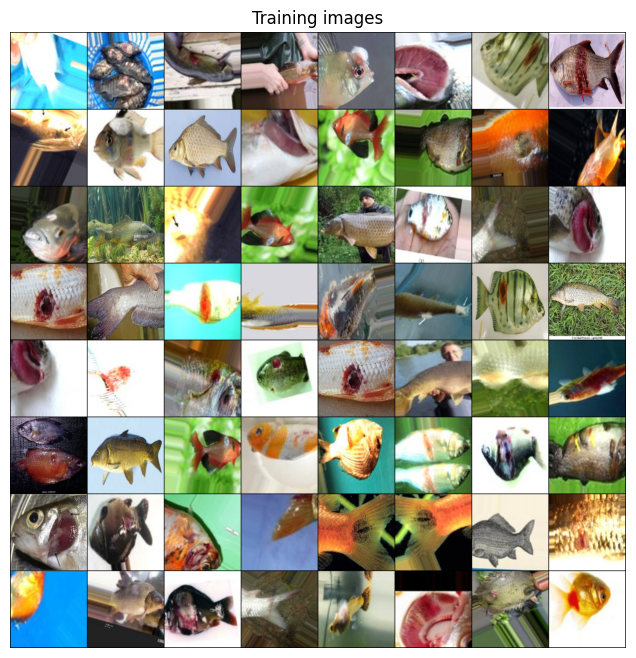

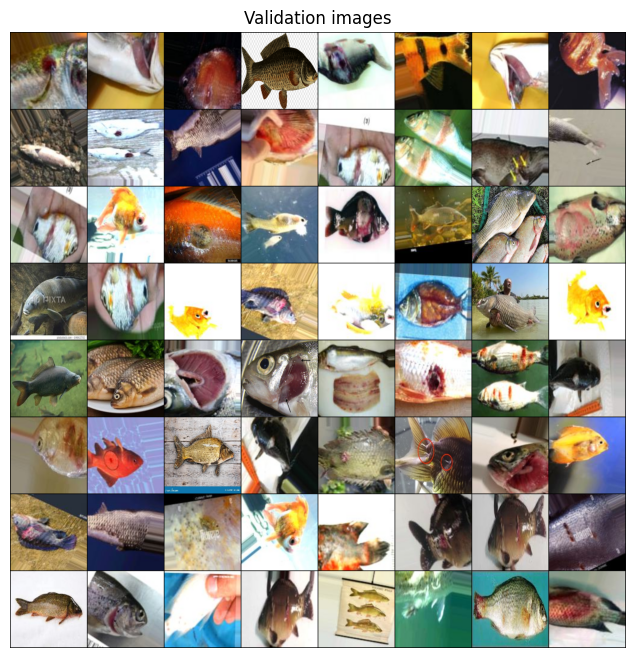

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision


print(get_model_list())

dm = FishDiseaseDataModule(height_width=(224, 224), batch_size=64, num_workers=4)
dm.prepare_data()
dm.setup()

for batch, (images, labels) in enumerate(dm.train_dataloader()):
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title("Training images")
    plt.imshow(np.transpose(torchvision.utils.make_grid(
        images[:64],
        padding=2,
        normalize=True),
        (1, 2, 0)))
    plt.show()
    # print(f"Batch {batch}: len(images) = {len(images)}, len(labels) = {len(labels)}")
    break


for batch, (images, labels) in enumerate(dm.val_dataloader()):
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title("Validation images")
    plt.imshow(np.transpose(torchvision.utils.make_grid(
        images[:64],
        padding=2,
        normalize=True),
        (1, 2, 0)))
    plt.show()
    # print(f"Batch {batch}: len(images) = {len(images)}, len(labels) = {len(labels)}")
    break

## 4) Training model

In [ ]:
import lightning as L
from lightning.pytorch.loggers import CSVLogger
import torch
import torchvision
from lightning.pytorch.callbacks import ModelCheckpoint

def train_model(resnet_type, augmentation):
    model_name = f"fish-disease-{resnet_type}-{augmentation}"
    print(f"training model {model_name}")

    if augmentation == "augmented":
        augment_data = True
    else:
        augment_data = False

    dm = FishDiseaseDataModule(height_width=(224, 224), batch_size=64, num_workers=2, augment_data=augment_data)

    pytorch_model = torch.hub.load('pytorch/vision', resnet_type, weights=None)
    num_ftrs = pytorch_model.fc.in_features # Get the number of features in the final FC layer
    pytorch_model.fc = torch.nn.Linear(num_ftrs, 7) # Replace the final FC layer with a new one with 7 outputs
    L.pytorch.seed_everything(123)
    print(pytorch_model)
    #------------------------------------------------------------------------
    lightning_model = LightningModel(model=pytorch_model, learning_rate=0.005)

    # Set up the checkpoint callback to save the model every 10 epochs
    checkpoint_callback = ModelCheckpoint(
        dirpath=f"Fish_Desease_checkpoints/{model_name}/",
        filename="{epoch}-{val_loss:.2f}",
        save_top_k=-1,  # Save all checkpoints based on the interval
        save_weights_only=True,  # Save only the model weights
        every_n_epochs=2,  # Save after every 10 epochs
    )

    trainer = L.Trainer(
        max_epochs=10,
        accelerator="auto",
        devices="auto",
        logger=CSVLogger(save_dir="Fish_Desease_logs/", name=model_name),
        deterministic=True,
        callbacks=[checkpoint_callback],
        log_every_n_steps=8,  # Log after every 8 batch
    )

    trainer.fit(model=lightning_model, datamodule=dm)
    torch.save(pytorch_model.state_dict(), f"{model_name}.pt") # lưu model cuối cùng sau khi chạy hết epochs
    plot_csv_logger(f"{trainer.logger.log_dir}/metrics.csv", model_name=model_name)

def train_models(model_list):
    for model in model_list:
        train_model(model, "baseline")
        #train_model(model, "augmented")


if __name__ == "__main__":
    model_list = get_model_list()
    train_models(model_list)

## Testing model

In [ ]:
import lightning as L
from lightning.pytorch.loggers import CSVLogger
import torch
import torchvision
from lightning.pytorch.callbacks import ModelCheckpoint

def test_model(resnet_type, augmentation):
    model_name = f"fish-disease-{resnet_type}-{augmentation}"
    print(f"testing model {model_name}")

    augment_data = augmentation == "augmented"
    dm = FishDiseaseDataModule(height_width=(224, 224), batch_size=128, num_workers=1, augment_data=augment_data)

    pytorch_model = torch.hub.load('pytorch/vision', resnet_type, weights=None)
    # Load the trained model weights
    # Before loading the state dict, modify the final FC layer to match the saved model
    num_ftrs = pytorch_model.fc.in_features
    pytorch_model.fc = torch.nn.Linear(num_ftrs, 7)  # Modify the FC layer to have 7 outputs

    pytorch_model.load_state_dict(torch.load(f"{model_name}.pt"))
    pytorch_model.eval()  # Set the model to evaluation mode

    lightning_model = LightningModel(model=pytorch_model, learning_rate=0.005)

    trainer = L.Trainer(
        accelerator="auto",
        devices="auto",
        logger=CSVLogger(save_dir="Fish_Desease_logs/", name=f"test-{model_name}"),
    )

    results = trainer.test(model=lightning_model, datamodule=dm)
    print(f"Test results for {model_name}: {results}")
    # plot_csv_logger(f"{trainer.logger.log_dir}/metrics.csv", model_name=f"test-{model_name}", eval_names=['test_acc'])


def test_models(model_list):
    for model in model_list:
        test_model(model, "baseline")
        test_model(model, "augmented")

if __name__ == "__main__":
    model_list = get_model_list()
    test_models(model_list)

## 5) Loading a model checkpoint \& Use Model On New Data

### 5.1) vẽ bộ ảnh mới không nhãn

Label_index:  {'Bacterial Red disease': 0, 'Bacterial diseases - Aeromoniasis': 1, 'Bacterial gill disease': 2, 'Fungal diseases Saprolegniasis': 3, 'Healthy Fish': 4, 'Parasitic diseases': 5, 'Viral diseases White tail disease': 6}
Label_index:  {'Bacterial Red disease': 0, 'Bacterial diseases - Aeromoniasis': 1, 'Bacterial gill disease': 2, 'Fungal diseases Saprolegniasis': 3, 'Healthy Fish': 4, 'Parasitic diseases': 5, 'Viral diseases White tail disease': 6}
Label_index:  {'Bacterial Red disease': 0, 'Bacterial diseases - Aeromoniasis': 1, 'Bacterial gill disease': 2, 'Fungal diseases Saprolegniasis': 3, 'Healthy Fish': 4, 'Parasitic diseases': 5, 'Viral diseases White tail disease': 6}
Số lượng mẫu train:  1750


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


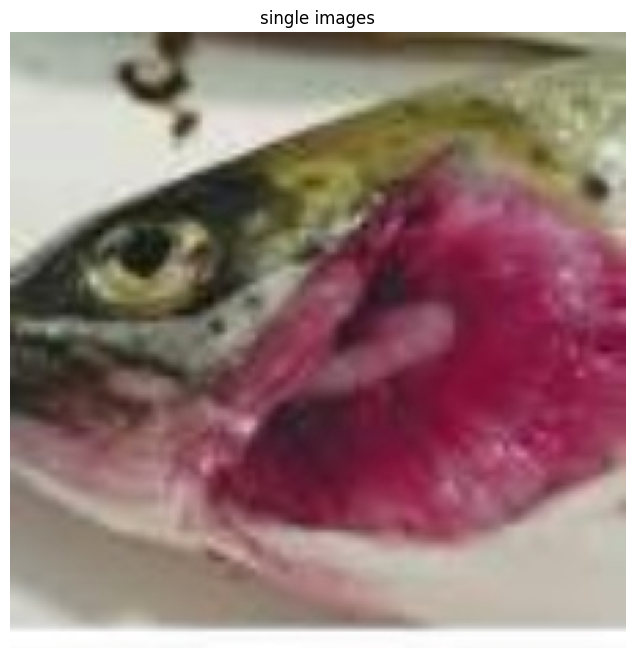

In [56]:
dm = FishDiseaseDataModule(height_width=(224, 224), batch_size=64, num_workers=4)
dm.prepare_data()
dm.setup()

for batch, (images) in enumerate(dm.single_dataloader()):
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title("single images")
    plt.imshow(np.transpose(torchvision.utils.make_grid(
        images[:64],
        padding=2,
        normalize=True),
        (1, 2, 0)))
    plt.show()
    # print(f"Batch {batch}: len(images) = {len(images)}, len(labels) = {len(labels)}")
    break

In [57]:
print(dm.single[0])

tensor([[[0.6784, 0.6784, 0.6784,  ..., 0.6431, 0.6392, 0.6392],
         [0.6784, 0.6784, 0.6745,  ..., 0.6510, 0.6510, 0.6471],
         [0.6745, 0.6745, 0.6745,  ..., 0.6745, 0.6745, 0.6745],
         ...,
         [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
         [1.0000, 1.0000, 1.0000,  ..., 0.9922, 0.9922, 0.9922],
         [0.9922, 0.9922, 0.9922,  ..., 0.9882, 0.9882, 0.9882]],

        [[0.7216, 0.7216, 0.7216,  ..., 0.6510, 0.6471, 0.6471],
         [0.7216, 0.7216, 0.7176,  ..., 0.6588, 0.6588, 0.6549],
         [0.7176, 0.7176, 0.7176,  ..., 0.6824, 0.6824, 0.6824],
         ...,
         [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
         [1.0000, 1.0000, 1.0000,  ..., 0.9922, 0.9922, 0.9922],
         [0.9922, 0.9922, 0.9922,  ..., 0.9882, 0.9882, 0.9882]],

        [[0.6667, 0.6667, 0.6667,  ..., 0.5647, 0.5608, 0.5608],
         [0.6667, 0.6667, 0.6627,  ..., 0.5725, 0.5725, 0.5686],
         [0.6627, 0.6627, 0.6627,  ..., 0.5882, 0.5961, 0.

testing model fish-disease-resnet18-baseline
Label_index:  {'Bacterial Red disease': 0, 'Bacterial diseases - Aeromoniasis': 1, 'Bacterial gill disease': 2, 'Fungal diseases Saprolegniasis': 3, 'Healthy Fish': 4, 'Parasitic diseases': 5, 'Viral diseases White tail disease': 6}
Label_index:  {'Bacterial Red disease': 0, 'Bacterial diseases - Aeromoniasis': 1, 'Bacterial gill disease': 2, 'Fungal diseases Saprolegniasis': 3, 'Healthy Fish': 4, 'Parasitic diseases': 5, 'Viral diseases White tail disease': 6}
Label_index:  {'Bacterial Red disease': 0, 'Bacterial diseases - Aeromoniasis': 1, 'Bacterial gill disease': 2, 'Fungal diseases Saprolegniasis': 3, 'Healthy Fish': 4, 'Parasitic diseases': 5, 'Viral diseases White tail disease': 6}
Số lượng mẫu train:  1750


Using cache found in /root/.cache/torch/hub/pytorch_vision_main


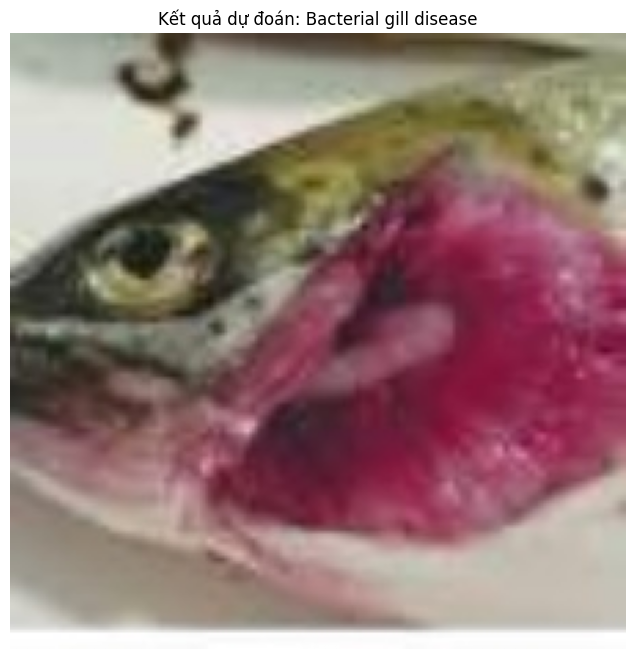

In [90]:
import lightning as L
from lightning.pytorch.loggers import CSVLogger
import torch
import torchvision
from lightning.pytorch.callbacks import ModelCheckpoint
from matplotlib import pyplot as plt

import numpy as np
dic = {'Bacterial Red disease': 0, 'Bacterial diseases - Aeromoniasis': 1, 'Bacterial gill disease': 2, 'Fungal diseases Saprolegniasis': 3, 'Healthy Fish': 4, 'Parasitic diseases': 5, 'Viral diseases White tail disease': 6}

def loading(resnet_type, augmentation):
    model_name = f"fish-disease-{resnet_type}-{augmentation}"
    print(f"testing model {model_name}")

    augment_data = augmentation == "augmented"
    dm = FishDiseaseDataModule(height_width=(224, 224), batch_size=128, num_workers=1, augment_data=augment_data)

    # Call the setup method to initialize the 'test' attribute before accessing it
    dm.setup()

    pytorch_model = torch.hub.load('pytorch/vision', resnet_type, weights=None)
    # Load the trained model weights
    # Before loading the state dict, modify the final FC layer to match the saved model
    num_ftrs = pytorch_model.fc.in_features
    pytorch_model.fc = torch.nn.Linear(num_ftrs, 7)  # Modify the FC layer to have 7 outputs

    # Provide learning_rate when loading from checkpoint
    lightning_model = LightningModel.load_from_checkpoint(
        checkpoint_path="/content/drive/MyDrive/Colab Notebooks/Fish_Desease_checkpoints/fish-disease-resnet18-baseline/epoch=27-val_loss=1.20.ckpt",
        model=pytorch_model,
        learning_rate=0.005 # Add learning_rate here
    )

    # Move the model to the appropriate device (GPU if available, otherwise CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    lightning_model.to(device)

    lightning_model.eval()
    with torch.inference_mode():
      # Move the input tensor to the same device as the model
      logit = lightning_model(dm.single[0].unsqueeze(0).to(device))
      pred = torch.argmax(logit, dim=1)
      for v in dic.items():
        if v[1] == pred:
          pred_label = "Kết quả dự đoán: "+ v[0]
          plt.figure(figsize=(8, 8))
          plt.axis("off")
          plt.title(pred_label)
          plt.imshow(np.transpose(dm.single[0],(1, 2, 0)))
          plt.show()
          break


def loadings(model_list):
    for model in model_list:
        loading(model, "baseline")
        # test_model(model, "augmented")

if __name__ == "__main__":
  model_list = get_model_list()
  loadings(model_list)